<a href="https://colab.research.google.com/github/mmilannaik/BigOCheatSheet/blob/master/Quantzig_Intransit%20Daage%20Classification_CPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap

# Data Generation

In [2]:
# 1. Data Generation (Imbalanced)
np.random.seed(42)
n = 5000  # Larger sample for more imbalance

data = pd.DataFrame({
    "Shipment_ID": range(1, n+1),
    "Route": np.random.choice(["A", "B", "C", "D"], n, p=[0.4, 0.2, 0.3, 0.1]),
    "Packaging": np.random.choice(["Standard", "Reinforced"], n, p=[0.85, 0.15]),
    "Truck_Type": np.random.choice(["Old", "New"], n, p=[0.1, 0.9]),
    "Driver_Exp": np.random.choice(["Junior", "Senior"], n, p=[0.25, 0.75]),
    "Weather": np.random.choice(["Clear", "Rainy", "Foggy"], n, p=[0.75, 0.20, 0.05]),
    "Distance_km": np.random.randint(10, 300, n),
})

# Lower base probabilities to make damages rare
damage_prob = (
    (data["Route"] == "B") * 0.04
    + (data["Packaging"] == "Standard") * 0.03
    + (data["Truck_Type"] == "Old") * 0.04
    + (data["Weather"] == "Rainy") * 0.03
    + (data["Weather"] == "Foggy") * 0.02
    + (data["Driver_Exp"] == "Junior") * 0.03
    + (data["Distance_km"] > 200) * 0.03
)

damage_prob += 0.01  # Add a very small base chance for everyone

data["Damage"] = (np.random.rand(n) < damage_prob).astype(int)

print("Damage rate (imbalanced):", data["Damage"].value_counts(normalize=True))


Damage rate (imbalanced): Damage
0    0.9258
1    0.0742
Name: proportion, dtype: float64


# EDA

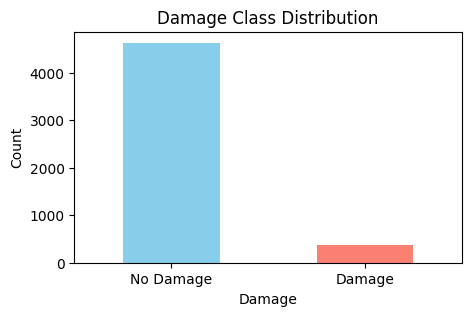

Damage rate:  0.0742


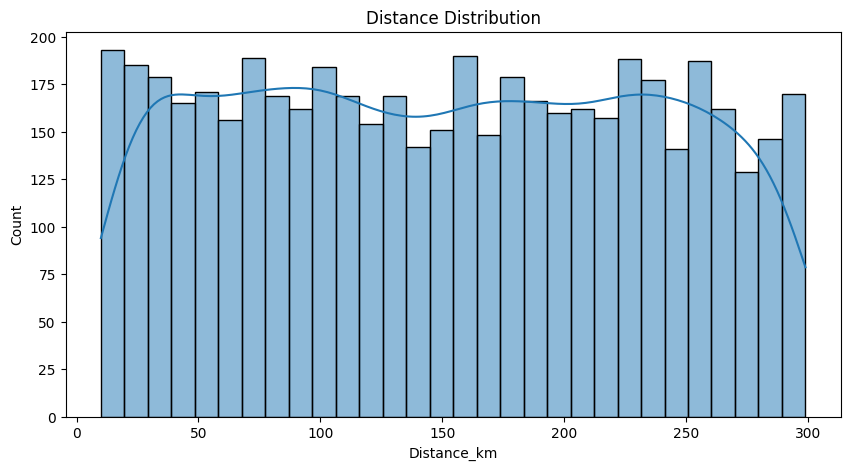

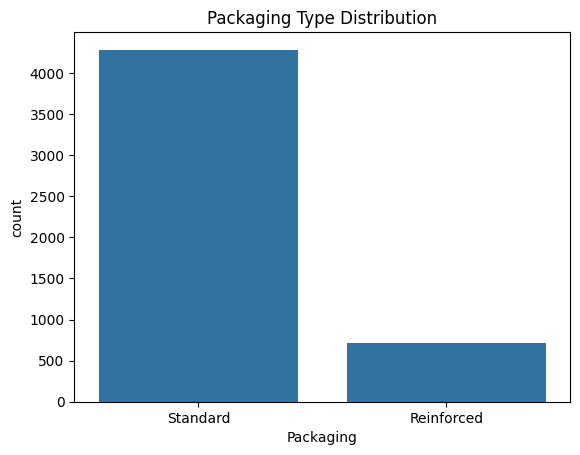

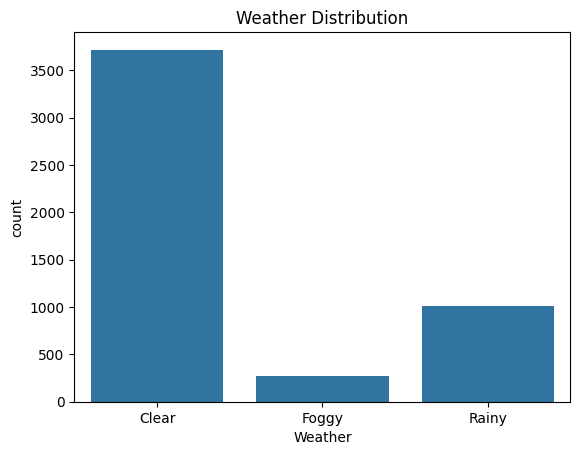

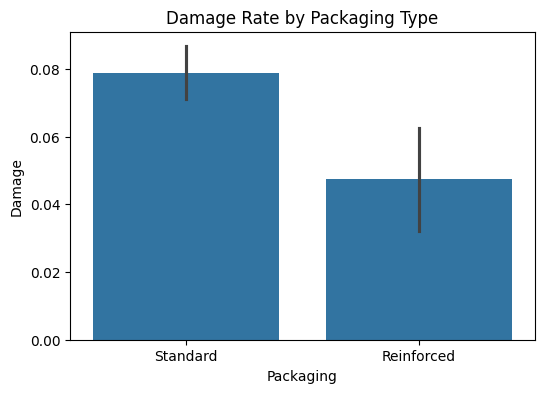

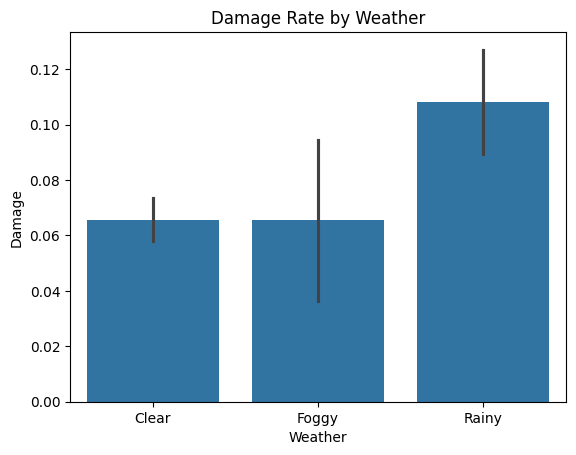

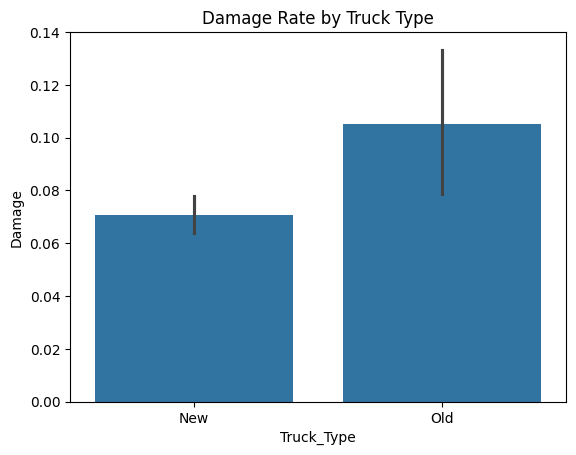

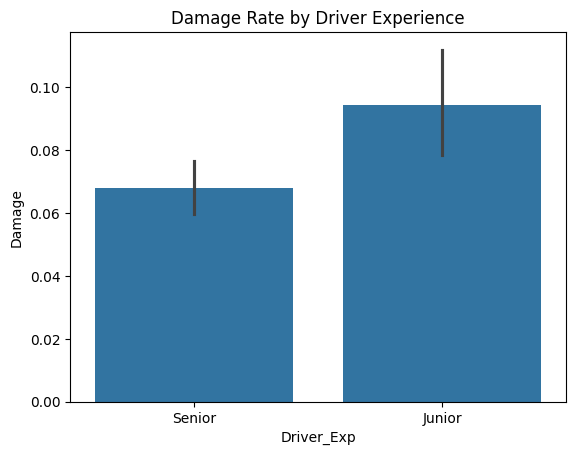

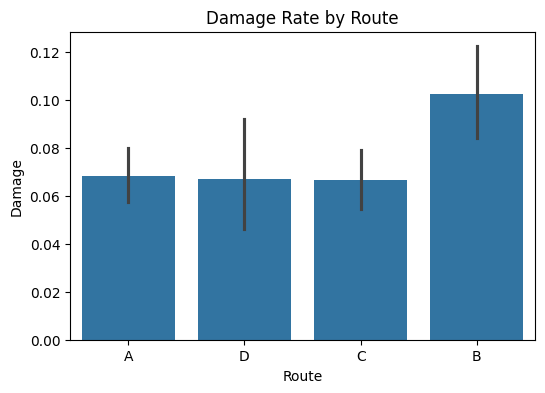

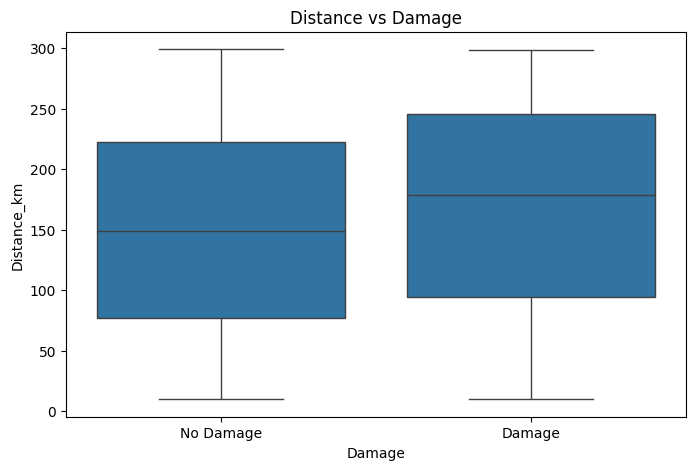

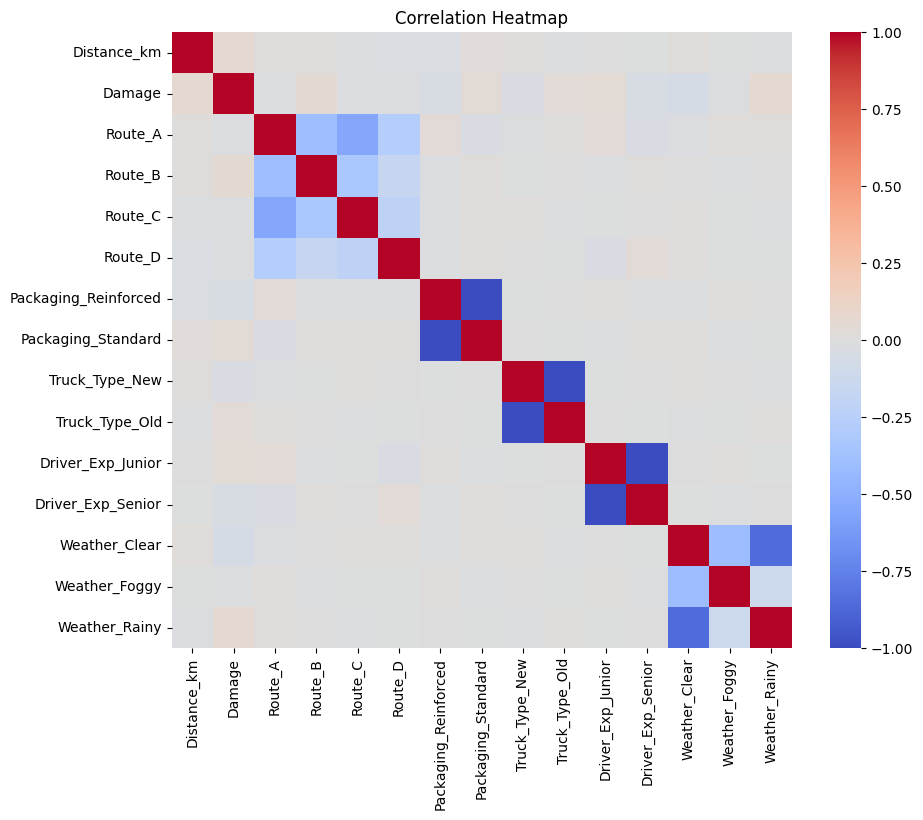

Any missing values?
 Shipment_ID    0
Route          0
Packaging      0
Truck_Type     0
Driver_Exp     0
Weather        0
Distance_km    0
Damage         0
dtype: int64


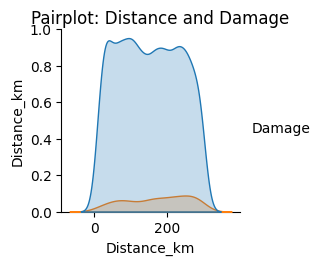

In [3]:
# 2. EDA (Exploratory Data Analysis)
plt.figure(figsize=(5,3))
data['Damage'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Damage Class Distribution')
plt.xticks([0,1], ['No Damage', 'Damage'], rotation=0)
plt.ylabel('Count')
plt.show()
print("Damage rate: ", data['Damage'].mean())

plt.figure(figsize=(10,5))
sns.histplot(data['Distance_km'], bins=30, kde=True)
plt.title('Distance Distribution')
plt.show()

sns.countplot(x='Packaging', data=data)
plt.title('Packaging Type Distribution')
plt.show()

sns.countplot(x='Weather', data=data)
plt.title('Weather Distribution')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='Packaging', y='Damage', data=data)
plt.title('Damage Rate by Packaging Type')
plt.show()

sns.barplot(x='Weather', y='Damage', data=data)
plt.title('Damage Rate by Weather')
plt.show()

sns.barplot(x='Truck_Type', y='Damage', data=data)
plt.title('Damage Rate by Truck Type')
plt.show()

sns.barplot(x='Driver_Exp', y='Damage', data=data)
plt.title('Damage Rate by Driver Experience')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='Route', y='Damage', data=data)
plt.title('Damage Rate by Route')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Damage', y='Distance_km', data=data)
plt.title('Distance vs Damage')
plt.xticks([0,1], ['No Damage', 'Damage'])
plt.show()

encoded = pd.get_dummies(data.drop(columns='Shipment_ID'))
corr = encoded.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

print('Any missing values?\n', data.isnull().sum())
sns.pairplot(data, vars=['Distance_km'], hue='Damage')
plt.suptitle('Pairplot: Distance and Damage', y=1.02)
plt.show()

## Insights- EDA

**Class imbalance**: Only about 7–9% of shipments have damage—confirms the need for imbalance handling.

**Feature impact** : Damage rates are higher for “Standard” packaging, “Old” trucks, “Junior” drivers, and bad weather (“Rainy”, “Foggy”).

**Route and distance**: Certain routes have higher damage; longer distances slightly increase risk.

**Visuals**: Used barplots and boxplots to quickly convey patterns and outliers.

During EDA, we discovered a strong class imbalance and clear risk patterns: damage was more common with standard packaging, older vehicles, junior drivers, and during rain/fog. These findings helped us justify feature selection and business rules. For instance, we confirmed with the operations team that old trucks are more prone to bumpy rides. EDA also made us vigilant for data quality issues before moving to modeling.”

## Insights- Missing Data

“We checked for missing values and imputed numerical columns using the median, which is robust to outliers, and categorical columns using the mode. For example, missing ‘Distance_km’ values were replaced with the median distance, and missing ‘Driver_Exp’ values were set to the most common experience level.”

3% of Distance_km and 2% of Driver_Exp are missing in the data used for modeling, EDA, and imputation.

## Feature Engineering

We engineered new features to add predictive power:

A binary **‘Is_Long_Distance’** flag for shipments over 200km

**‘Route_Risk’** based on historical damage rate for each route

**‘Weather_Severity’** as an ordinal score

**‘Driver_Exp_Level’** (Senior=1, Junior=0)

**‘Combined_Risk’**  to aggregate several risk factors
These features helped the model learn important patterns and improved predictive accuracy.”